# Aequitas

In [339]:
# from aequitas import Audit

# import aequitas.plot as ap
import pandas as pd

from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, false_negative_rate, true_positive_rate, true_negative_rate,equalized_odds_difference
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.preprocessing import LabelEncoder


In [340]:
columns_to_select = [
    "sex", "age_cat", "race", "juv_fel_count", "decile_score", "juv_misd_count", "juv_other_count", 
    "c_charge_degree", "is_recid", "r_charge_degree", "is_violent_recid", 
    "vr_charge_degree", "score_text", "v_score_text", "two_year_recid", "days_b_screening_arrest",
    "score_factor", "predicted_score"
]

df = pd.read_csv("compas_with_predictions.csv")[columns_to_select]



In [341]:
# drop rows with missing values
df = df.dropna()

# drop row with race = Asian
df = df[df['race'] != 'Asian']

In [342]:
df = df.drop(columns=['days_b_screening_arrest'])

In [343]:
# convert columns to categorical
for column in df.columns:
    df[column] = df[column].astype('object')
    
# convert target columns to numerical

df['score_factor'] = df['score_factor'].astype('int')

In [344]:
# select a row where race = Caucasian, sex = Male, age_cat = 25-45, recidivism = no, c_charge_degree = F, decile_score = 5, juv_fel_count = 0, juv_misd_count = 0, juv_other_count = 0, r_charge_degree = F, vr_charge_degree = F, score_text = Low, v_score_text = Low, two_year_recid = 0
# this row will be used as reference group
reference = df.loc[(df['race'] == 'Caucasian') & (df['sex'] == 'Male') & (df['age_cat'] == '25 - 45') & (df['score_text'] == 'Low')]
                       
                       
reference = reference.iloc[0]
reference.drop(['predicted_score', 'score_factor'], inplace=True)

reference = reference.to_dict()
reference

{'sex': 'Male',
 'age_cat': '25 - 45',
 'race': 'Caucasian',
 'juv_fel_count': 0,
 'decile_score': 3,
 'juv_misd_count': 0,
 'juv_other_count': 0,
 'c_charge_degree': 'M',
 'is_recid': 1,
 'r_charge_degree': '(M2)',
 'is_violent_recid': 1,
 'vr_charge_degree': '(M1)',
 'score_text': 'Low',
 'v_score_text': 'Low',
 'two_year_recid': 1}

In [345]:

# audit = Audit(df, 
#               label_column="predicted_score", 
#               score_column="score_factor", 
#               sensitive_attribute_column=["sex", "age_cat", "race", "is_recid", "is_violent_recid", "c_charge_degree", "decile_score", "juv_fel_count", "juv_misd_count", "juv_other_count", "r_charge_degree", "vr_charge_degree", "score_text", "v_score_text", "two_year_recid"],
#               reference_groups=reference)
# audit.audit()

In [346]:
# audit.confusion_matrix

In [347]:
# audit.metrics.round(2)

In [348]:
# metrics = ['fpr','fdr']
# disparity_tolerance = 1.25

In [349]:
# audit.disparities.style

In [350]:
# audit.disparity_plot(metrics=metrics, attribute='race', fairness_threshold=disparity_tolerance)

In [351]:
# from aequitas.group import Group

# group = Group()
# xtab = group.get_crosstabs(df, score_col='score_factor', label_col='predicted_score', attr_cols = ["sex", "age_cat", "race", "is_recid", "is_violent_recid", "c_charge_degree", "decile_score", "juv_fel_count", "juv_misd_count", "juv_other_count", "r_charge_degree", "vr_charge_degree", "score_text", "v_score_text", "two_year_recid"])

# xtab = xtab[0]
# xtab

In [352]:
# from aequitas.bias import Bias

# bias = Bias()
# hbdf = bias.get_disparity_predefined_groups(df=xtab, original_df=df, ref_groups_dict=reference, alpha=0.05, mask_significance=True)

In [353]:
# hbdf[['attribute_name', 'attribute_value'] +
#      bias.list_disparities(hbdf) + bias.list_significance(hbdf)]

In [354]:
# majority_bdf = bias.get_disparity_major_group(xtab, original_df=df)
# majority_bdf[['attribute_name', 'attribute_value'] +  bias.list_disparities(majority_bdf)]

## Fairness

In [355]:
# from aequitas.fairness import Fairness

# f = Fairness()
# fdf = f.get_fairness_measures_supported(majority_bdf)

# x = f.get_group_value_fairness(majority_bdf)

# fdf

# FairLearn

In [356]:
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'selection_rate': selection_rate,
    'false_positive_rate': false_positive_rate,
    'false_negative_rate': false_negative_rate,
    'true_positive_rate': true_positive_rate,
    'true_negative_rate': true_negative_rate
}


In [357]:
# métricas para cada grupo sensível
metric_frame = MetricFrame(metrics=metrics, 
                           y_true=df['predicted_score'], 
                           y_pred=df['score_factor'], 
                           sensitive_features=df['race'])
                           
# Calcular disparidades
disparities = metric_frame.difference()
print(disparities)

accuracy               0.243243
precision              0.444444
recall                 0.202381
selection_rate         0.513514
false_positive_rate    0.388235
false_negative_rate    0.202381
true_positive_rate     0.202381
true_negative_rate     0.754902
dtype: float64


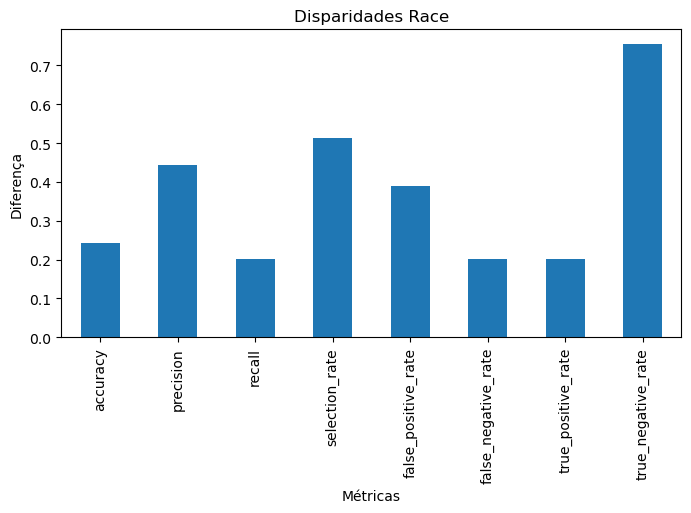

In [358]:
disparities.plot(kind='bar', figsize=(8, 4))
plt.title('Disparidades Race')
plt.xlabel('Métricas')
plt.ylabel('Diferença')
plt.show()

In [359]:
# métricas para cada grupo sensível
metric_frame = MetricFrame(metrics=metrics, 
                           y_true=df['predicted_score'], 
                           y_pred=df['score_factor'], 
                           sensitive_features=df['sex'])
                           
# Calcular disparidades
disparities = metric_frame.difference()
print(disparities)

accuracy               0.020694
precision              0.049468
recall                 0.035784
selection_rate         0.063065
false_positive_rate    0.041288
false_negative_rate    0.035784
true_positive_rate     0.035784
true_negative_rate     0.041288
dtype: float64


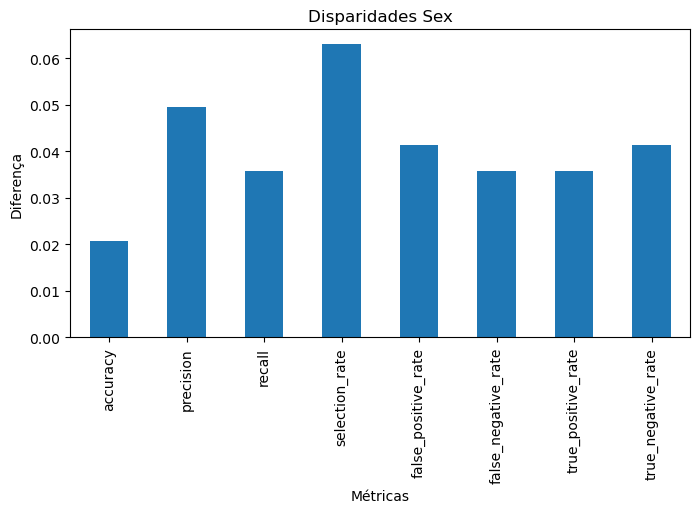

In [360]:
disparities.plot(kind='bar', figsize=(8, 4))
plt.title('Disparidades Sex')
plt.xlabel('Métricas')
plt.ylabel('Diferença')
plt.show()

In [361]:
# métricas para cada grupo sensível
metric_frame = MetricFrame(metrics=metrics, 
                           y_true=df['predicted_score'], 
                           y_pred=df['score_factor'], 
                           sensitive_features=df['age_cat'])
                           
# Calcular disparidades
disparities = metric_frame.difference()
print(disparities)

accuracy               0.050909
precision              0.458904
recall                 0.146718
selection_rate         0.431961
false_positive_rate    0.354098
false_negative_rate    0.146718
true_positive_rate     0.146718
true_negative_rate     0.354098
dtype: float64


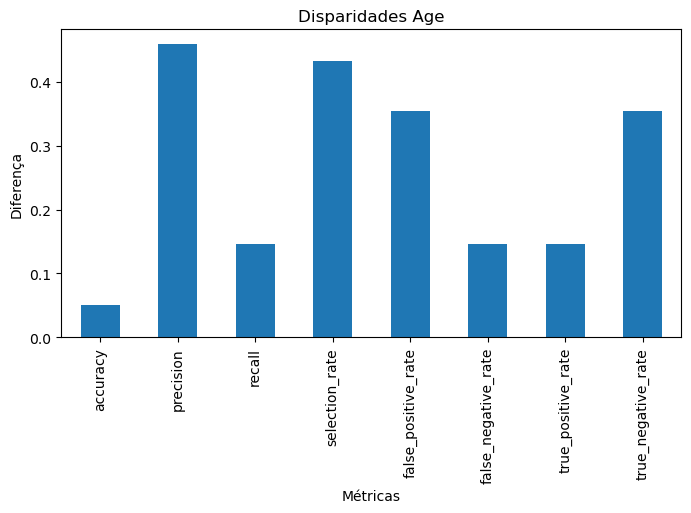

In [362]:
disparities.plot(kind='bar', figsize=(8, 4))
plt.title('Disparidades Age')
plt.xlabel('Métricas')
plt.ylabel('Diferença')
plt.show()

***equalized_odds_difference*** e ***equalized_odds_ratio*** -> estas medem as disparidades em verdadeiros positivos e falsos positivos entre grupos, portanto pode ser fixe para o nosso

In [363]:
eod_race = equalized_odds_difference(y_true=df['predicted_score'], 
                                     y_pred=df['score_factor'], 
                                     sensitive_features=df['race'])

print(f'Equalized Odds Difference (Race): {eod_race}')

eod_sex = equalized_odds_difference(y_true=df['predicted_score'], 
                                    y_pred=df['score_factor'], 
                                    sensitive_features=df['sex'])

print(f'Equalized Odds Difference (Sex): {eod_sex}')

eod_age = equalized_odds_difference(y_true=df['predicted_score'], 
                                    y_pred=df['score_factor'], 
                                    sensitive_features=df['age_cat'])

print(f'Equalized Odds Difference (Age): {eod_age}')

Equalized Odds Difference (Race): 0.38823529411764707
Equalized Odds Difference (Sex): 0.04128751867445335
Equalized Odds Difference (Age): 0.3540983606557377


In [364]:
# Calcular True Positive Rate e False Positive Rate por grupo sensível
tpr_race = MetricFrame(metrics=true_positive_rate, y_true=df['predicted_score'], 
                       y_pred=df['score_factor'], sensitive_features=df['race'])
fpr_race = MetricFrame(metrics=false_positive_rate, y_true=df['predicted_score'], 
                       y_pred=df['score_factor'], sensitive_features=df['race'])

# Calcular razão entre True Positive Rate e False Positive Rate dos grupos
tpr_ratio = tpr_race.overall / tpr_race.by_group
fpr_ratio = fpr_race.overall / fpr_race.by_group

Um **TPR** alto significa que o modelo consegue identificar bem os casos positivos.

In [365]:
print(f'Equalized Odds Ratio (TPR): {tpr_ratio}')


Equalized Odds Ratio (TPR): race
African-American    0.994906
Caucasian           1.046160
Hispanic            0.962812
Native American     0.834437
Other               0.917881
Name: true_positive_rate, dtype: float64


Um **FPR** baixo indica que o modelo não está a gerar muitos falsos alarmes.

In [366]:
print(f'Equalized Odds Ratio (FPR): {fpr_ratio}')


Equalized Odds Ratio (FPR): race
African-American    0.785824
Caucasian           1.244746
Hispanic            1.169492
Native American          inf
Other               0.991525
Name: false_positive_rate, dtype: float64


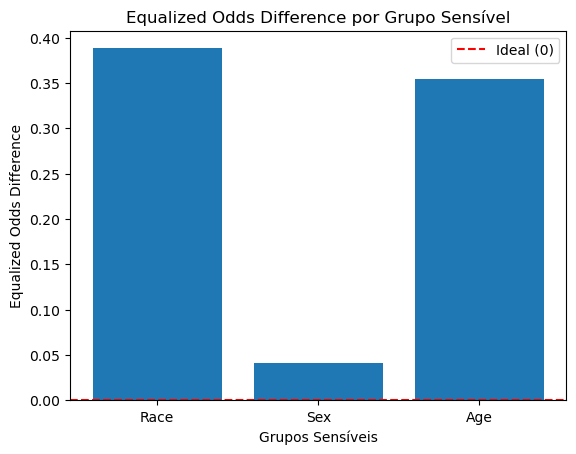

In [367]:
eod_metrics = {
    'Race': eod_race,
    'Sex': eod_sex,
    'Age': eod_age
}


plt.bar(eod_metrics.keys(), eod_metrics.values())
plt.title('Equalized Odds Difference por Grupo Sensível')
plt.ylabel('Equalized Odds Difference')
plt.xlabel('Grupos Sensíveis')
plt.axhline(0, color='red', linestyle='--', label='Ideal (0)')
plt.legend()
plt.show()


# AIF360

Necessário passar todas as variáveis para numéricas.

In [368]:
categorical_columns = [
    'score_text', 'v_score_text', 'c_charge_degree', 'age_cat', 'sex',
    'r_charge_degree', 'vr_charge_degree', 'race'
]

for col in categorical_columns:
    df[col] = df[col].astype(str)

label_encoder = LabelEncoder()

for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])


print(label_encoder.classes_)
df['score_factor'] = df['score_factor'].astype(int)
df['decile_score'] = df['decile_score'].astype(int)
print(df['race'].value_counts())
sensitive_features = ['race']  
target_column = 'score_factor'

aif_dataset = BinaryLabelDataset(
    favorable_label=0,  
    unfavorable_label=1,  
    df=df,  
    label_names=['predicted_score'],
    protected_attribute_names=sensitive_features
)

['African-American' 'Caucasian' 'Hispanic' 'Native American' 'Other']
race
0    426
1    186
2     38
4     37
3      2
Name: count, dtype: int64


In [369]:
dataset_metric = BinaryLabelDatasetMetric(aif_dataset, 
                                          privileged_groups=[{'race': 1}], 
                                          unprivileged_groups=[{'race': 0}])

print("Disparate Impact:", dataset_metric.disparate_impact())
print("Statistical Parity Difference:", dataset_metric.statistical_parity_difference())

classification_metric = ClassificationMetric(
    aif_dataset,  
    aif_dataset,  
    privileged_groups=[{'race': 1}],
    unprivileged_groups=[{'race': 0}]
)

print("Equal Opportunity Difference:", classification_metric.equal_opportunity_difference())
print("Average Odds Difference:", classification_metric.average_odds_difference())

Disparate Impact: 0.363849765258216
Statistical Parity Difference: -0.34885658034226863
Equal Opportunity Difference: 0.0
Average Odds Difference: 0.0


 O **Disparate Impact** mede o quanto a probabilidade de um grupo protegido (neste caso, provavelmente um grupo com base na raça, como "Caucasian" ou "African-American") ser favorecido pelo modelo é desigual em relação a outro grupo. Um valor de Disparate Impact abaixo de 0,8 indica que o modelo pode estar discriminando negativamente um dos grupos.
 
 Um **Disparate Impact** de 0.3638 significa que o modelo está tratando o grupo não privilegiado (provavelmente, "African-American") de forma significativamente mais desfavorável do que o grupo privilegiado (provavelmente, "Caucasian").

O **Statistical Parity Difference** mede a diferença entre as taxas de aprovação (ou de um evento favorável) para o grupo privilegiado e o grupo não privilegiado. Essencialmente, ele calcula a diferença de probabilidade de um resultado favorável entre esses grupos. Um valor de 0 indica que as taxas de aprovação são iguais para ambos os grupos.

Um **Statistical Parity Difference** de -0.3489 significa que a taxa de aprovação para o grupo não privilegiado (provavelmente "African-American") é significativamente menor do que para o grupo privilegiado (provavelmente "Caucasian").

O **Equal Opportunity Difference** mede a diferença nas taxas de verdadeiro positivo (True Positive Rate, TPR) entre os grupos privilegiado e não privilegiado. O TPR é a proporção de indivíduos que receberam uma previsão positiva entre aqueles que realmente são positivos. 0.0 é o valor ideal, pois significa que o modelo não está favorecendo nem prejudicando um grupo em relação ao outro em termos de identificar indivíduos positivos corretamente.

O **Average Odds Difference** mede a diferença entre as taxas de falsos positivos e verdadeiros positivos entre os dois grupos. Ele combina a diferença nas taxas de verdadeiro positivo (TPR) e a diferença nas taxas de falso positivo (FPR). Um valor de 0.0 significa que as taxas médias de erro para ambos os grupos (privilegiado e não privilegiado) são iguais. O modelo não está gerando mais erros para um grupo do que para o outro.

In [370]:
RW = Reweighing(unprivileged_groups=[{'race': 0}],
                privileged_groups=[{'race': 1}])

aif_dataset_transf = RW.fit_transform(aif_dataset)

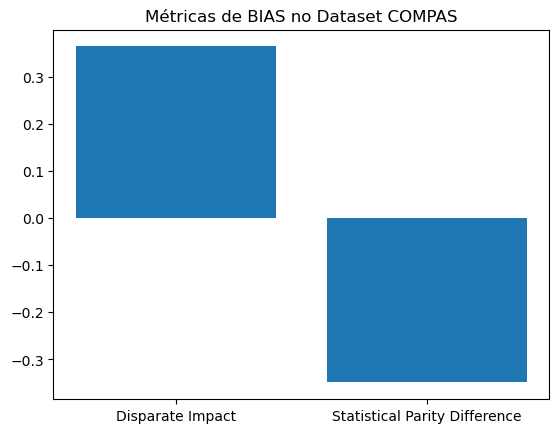

In [371]:
metrics = ["Disparate Impact", "Statistical Parity Difference"]
values = [dataset_metric.disparate_impact(), dataset_metric.statistical_parity_difference()]

plt.bar(metrics, values)
plt.title("Métricas de BIAS no Dataset COMPAS")
plt.show()